# WordCount for Appstore reviews for popular virtual platforms

To parse AppStore reviews, I use app_store_scraper and iteratively collect data form different app reviews in US

In [14]:
!pip install app_store_scraper

In [3]:
#Import all the nessesary packages

from app_store_scraper import AppStore
import pandas as pd
import numpy as np
import json
from wordcloud import WordCloud

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords =stopwords.words('english')

#not all default stopwords parameters catch unessesary words in reviews, so I extend this list with other words
stopwords.extend(['it’s', 'also', 'would','don’t','i’m', 'i’ve']) 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(rc=custom_params, palette = 'pastel')


from pyspark import SparkConf
from pyspark.sql import SparkSession

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vladislavcesnokov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Getting data

In [4]:
### Set AppStore ID and AppStore app name from appstore link
AppStoreDict = {'686449807': 'telegram-messenger', 
                '333903271': 'twitter', 
                '310633997': 'whatsapp-messenger', 
                '389801252': 'instagram',
                '284882215': 'facebook',
                '414478124': 'wechat',
               '874139669': 'signal-private-messenger',
               '447188370': 'snapchat',
               '429047995': 'pinterest',
               '985746746': 'discord-chat-talk-hangout'}

### Create dictionary with links and app names for ease of future iterative work
LocalAppDict = dict()

for key in AppStoreDict:
    app = AppStore(country='us', app_name=AppStoreDict[key], app_id = key)
    
    ###Set the number of reviews
    app.review(how_many=200)
    
    ###Create dataframe
    df = pd.DataFrame(np.array(app.reviews),columns=['review'])
    df2 = df.join(pd.DataFrame(df.pop('review').tolist()))
    
    ### Select only review columns
    review_only = df2['review']
    
    ### Set path for data import
    name = '/Users/vladislavcesnokov/Desktop/HW2 Data/App Store Review '+AppStoreDict[key]+'.csv'
    
    ### Save data in a folder
    review_only.to_csv(name, header=None,index=False)
    LocalAppDict[AppStoreDict[key]] = name

2022-03-28 23:45:04,679 [INFO] Base - Initialised: AppStore('us', 'telegram-messenger', 686449807)
2022-03-28 23:45:04,681 [INFO] Base - Ready to fetch reviews from: https://apps.apple.com/us/app/telegram-messenger/id686449807
2022-03-28 23:45:09,746 [INFO] Base - [id:686449807] Fetched 60 reviews (60 fetched in total)
2022-03-28 23:45:17,145 [INFO] Base - [id:686449807] Fetched 160 reviews (160 fetched in total)
2022-03-28 23:45:20,127 [INFO] Base - [id:686449807] Fetched 200 reviews (200 fetched in total)
2022-03-28 23:45:21,765 [INFO] Base - Initialised: AppStore('us', 'twitter', 333903271)
2022-03-28 23:45:21,766 [INFO] Base - Ready to fetch reviews from: https://apps.apple.com/us/app/twitter/id333903271
2022-03-28 23:45:28,012 [INFO] Base - [id:333903271] Fetched 80 reviews (80 fetched in total)
2022-03-28 23:45:34,736 [INFO] Base - [id:333903271] Fetched 160 reviews (160 fetched in total)
2022-03-28 23:45:37,876 [INFO] Base - [id:333903271] Fetched 200 reviews (200 fetched in tot

In [5]:
LocalAppDict ### Check local app dictionary

{'telegram-messenger': '/Users/vladislavcesnokov/Desktop/HW2 Data/App Store Review telegram-messenger.csv',
 'twitter': '/Users/vladislavcesnokov/Desktop/HW2 Data/App Store Review twitter.csv',
 'whatsapp-messenger': '/Users/vladislavcesnokov/Desktop/HW2 Data/App Store Review whatsapp-messenger.csv',
 'instagram': '/Users/vladislavcesnokov/Desktop/HW2 Data/App Store Review instagram.csv',
 'facebook': '/Users/vladislavcesnokov/Desktop/HW2 Data/App Store Review facebook.csv',
 'wechat': '/Users/vladislavcesnokov/Desktop/HW2 Data/App Store Review wechat.csv',
 'signal-private-messenger': '/Users/vladislavcesnokov/Desktop/HW2 Data/App Store Review signal-private-messenger.csv',
 'snapchat': '/Users/vladislavcesnokov/Desktop/HW2 Data/App Store Review snapchat.csv',
 'pinterest': '/Users/vladislavcesnokov/Desktop/HW2 Data/App Store Review pinterest.csv',
 'discord-chat-talk-hangout': '/Users/vladislavcesnokov/Desktop/HW2 Data/App Store Review discord-chat-talk-hangout.csv'}

## Counting Words

In [6]:
spark=SparkSession.builder\
    .master("local[*]")\
    .appName("WordCount")\
    .getOrCreate()

sc=spark.sparkContext

#Remove Punctuation and Transform All Words to Lowercase
def lower_clean_str(x):
  punc='!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~-'
  lowercased_str = x.lower()
  for ch in punc:
    lowercased_str = lowercased_str.replace(ch, '')
  return lowercased_str

df = pd.DataFrame()

for key in LocalAppDict:
    path = LocalAppDict[key]
    apps_rdd=sc.textFile(path)
    apps_rdd = apps_rdd.map(lower_clean_str)
    
    #Split sentence into list of words
    apps_rdd=apps_rdd.flatMap(lambda satir: satir.split(" "))
    
    #Exclude whitespaces
    apps_rdd = apps_rdd.filter(lambda x:x!='')
    
    #Count how many times each word occurs
    apps_count=apps_rdd.map(lambda  word:(word,1))
    
    ##Apply ReduceByKey, rank words and exclude stopwords
    apps_count_RBK=apps_count.reduceByKey(lambda x,y:(x+y)).sortByKey()
    apps_count_RBK=apps_count_RBK.map(lambda x:(x[1],x[0]))
    apps_count_RBK = apps_count_RBK.filter(lambda x: x[1] not in stopwords).sortByKey(False)
    deptDF = spark.createDataFrame(apps_count_RBK, schema = ['Count', 'Word'])
    pandasDF = deptDF.toPandas()
    pandasDF['Flag'] = key
    df = pd.concat([df, pandasDF], ignore_index = True)

22/03/28 23:48:22 WARN Utils: Your hostname, MacBook-Pro-Vladislav.local resolves to a loopback address: 127.0.0.1; using 192.168.0.111 instead (on interface en0)
22/03/28 23:48:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/03/28 23:48:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/03/28 23:48:24 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/03/28 23:48:24 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/03/28 23:48:24 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
22/03/28 23:48:24 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.


In [8]:
df.groupby(['Word']).sum().sort_values('Count', ascending = 0)[:10] #See 10 most frequent words in reviewsdf.sort_values('Count', ascending = 0)[:10] #See 10 most frequent words in reviews

Count
Word          
app       3168
like      1519
people    1221
account   1111
one       1029
get       1013
use        973
even       934
time       855
see        831

## Visualization

### Wordclouds

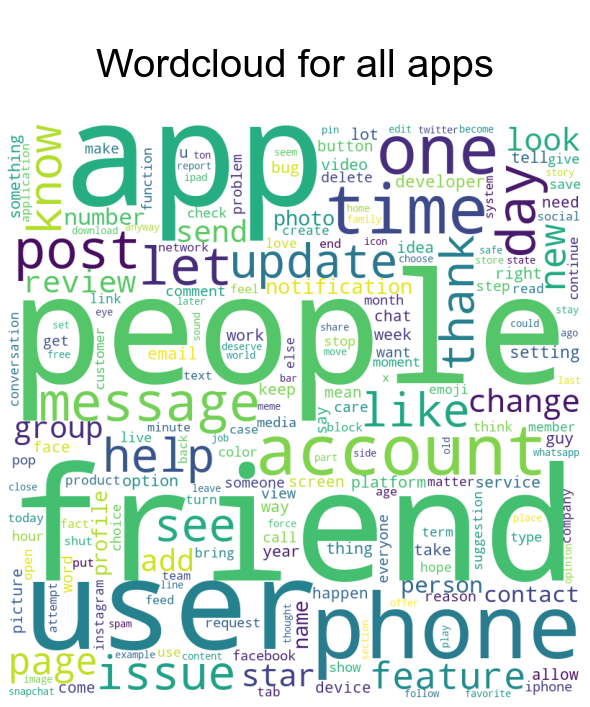

In [20]:
comment_words = ''

#Build wordcloud for every app
for val in df['Word']:
    tokens = str(val)
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title(label='\n'+ "Wordcloud for all apps"+'\n', fontsize=40, color="Black")
plt.show()
comment_words = ''

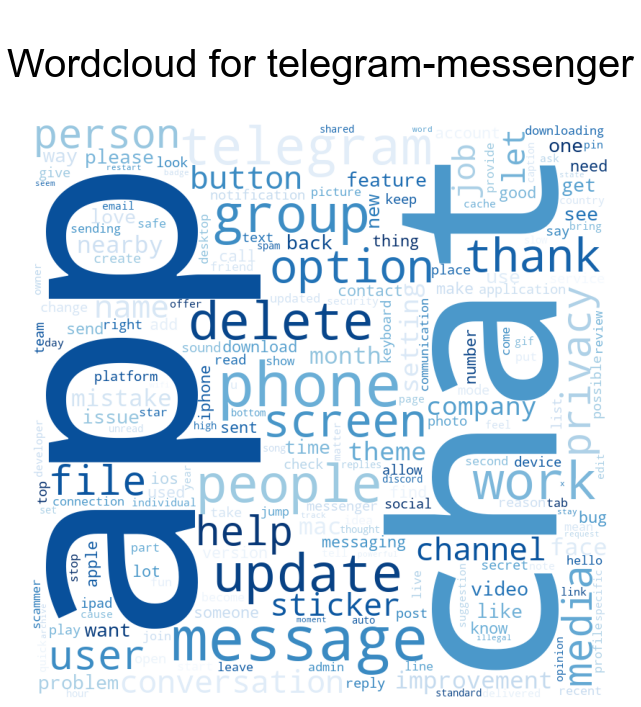

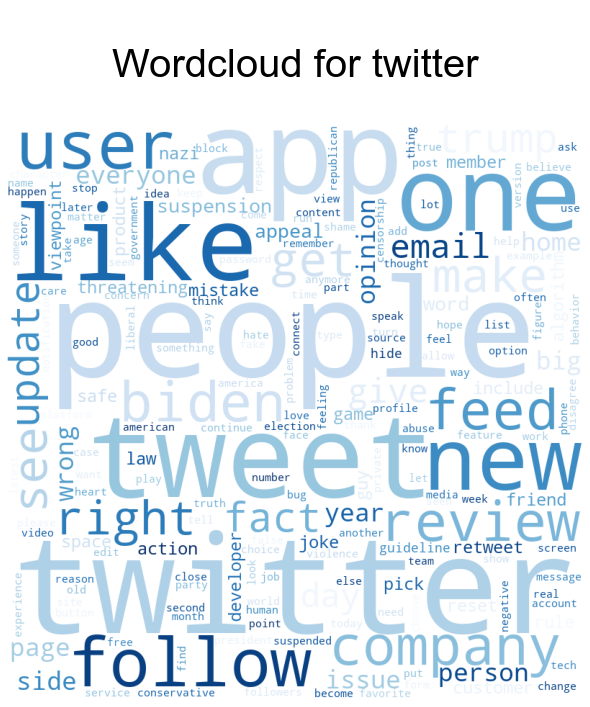

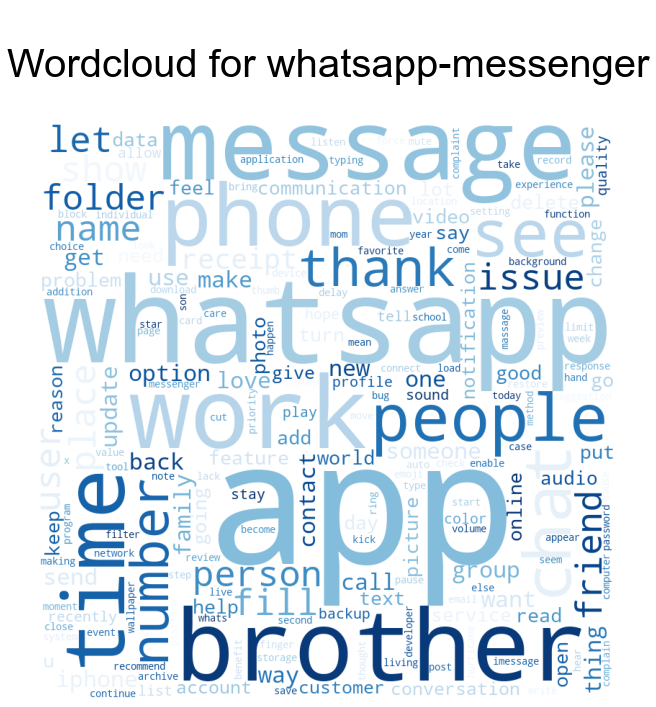

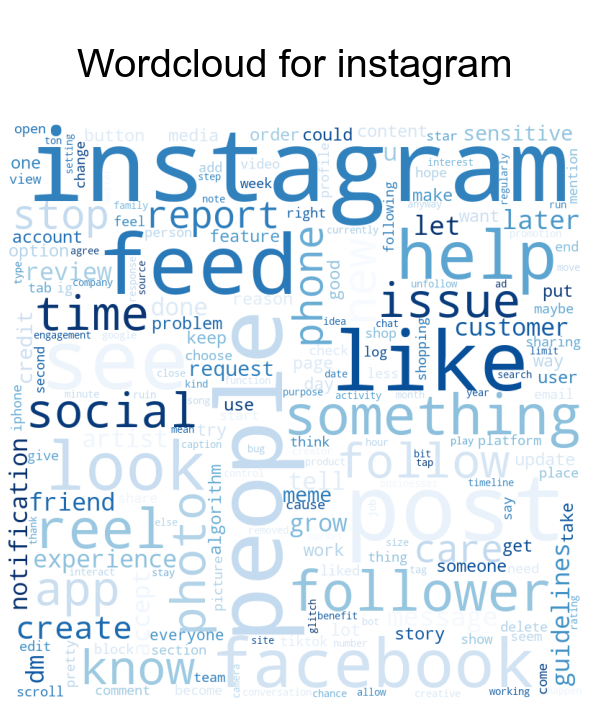

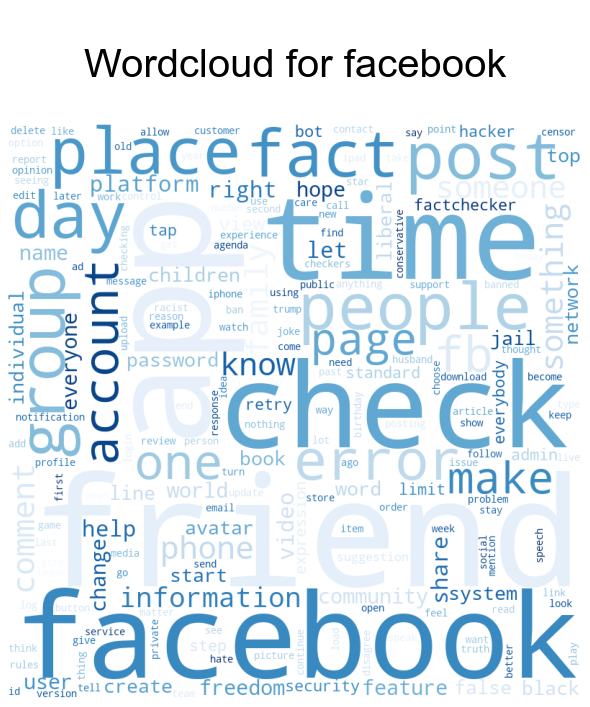

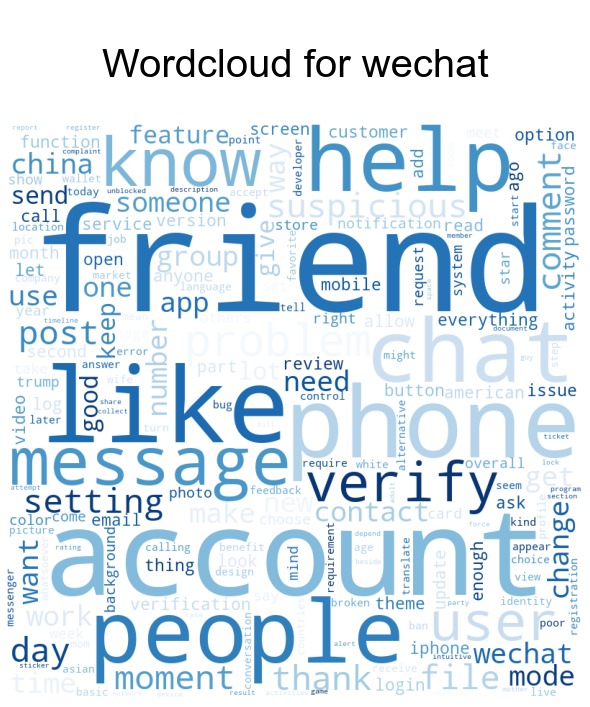

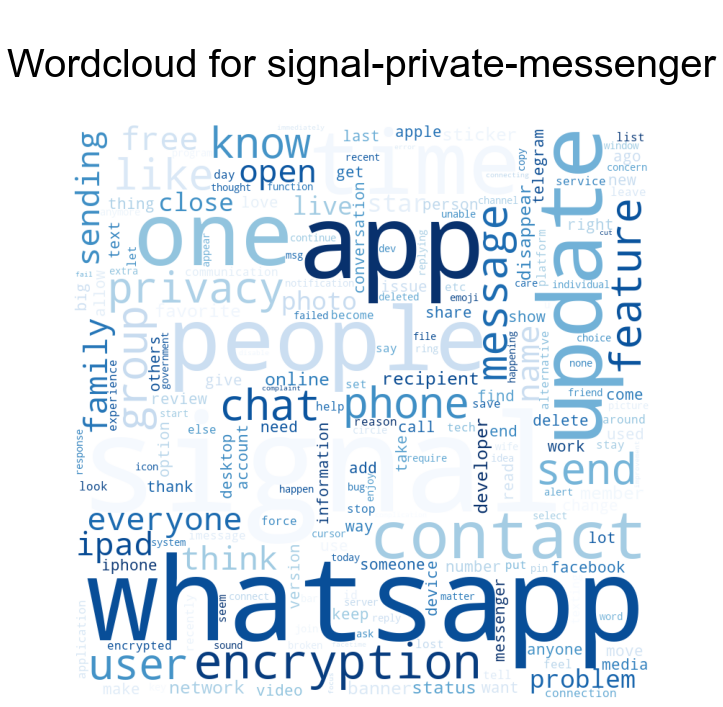

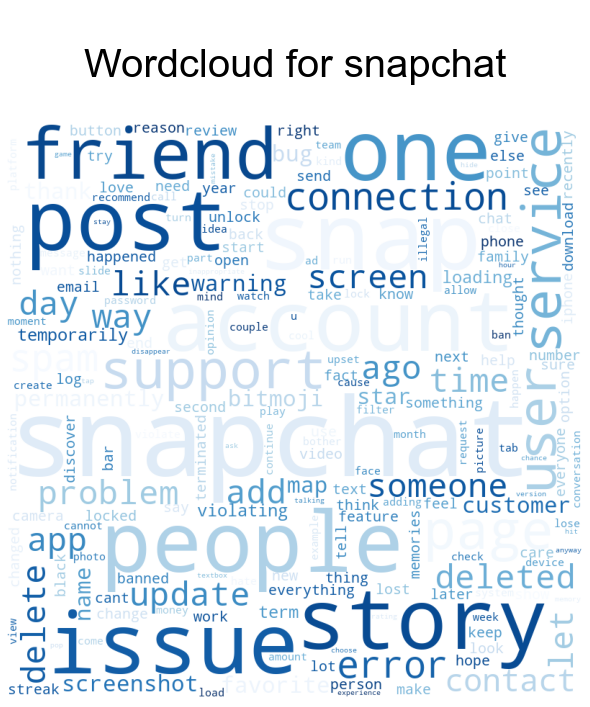

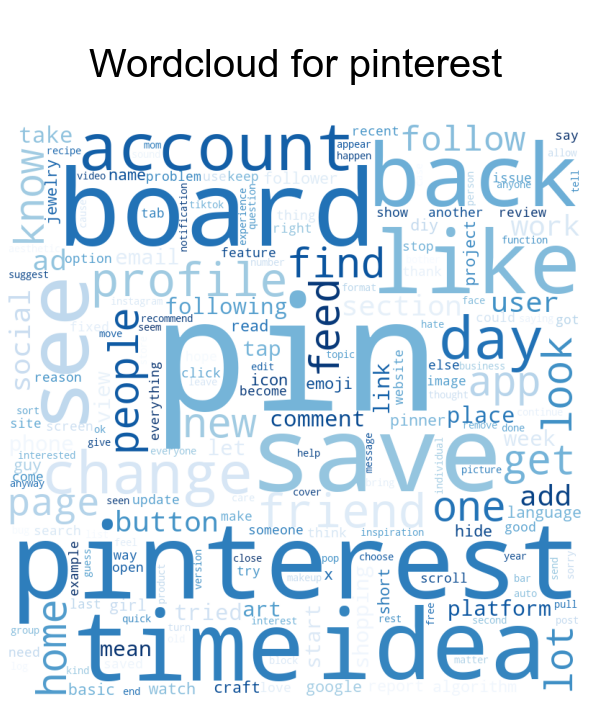

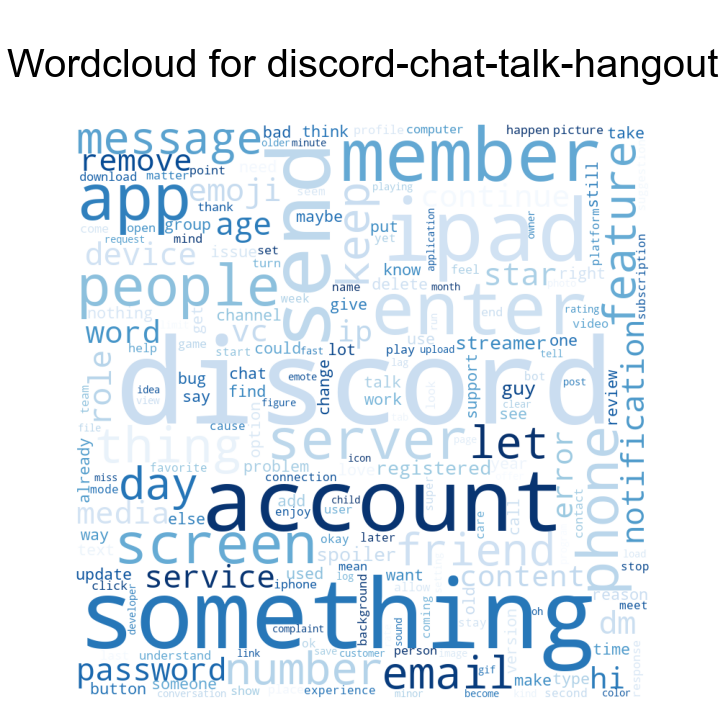

22/03/28 02:15:39 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1962720 ms exceeds timeout 120000 ms
22/03/28 02:15:39 WARN SparkContext: Killing executors is not supported by current scheduler.


In [25]:
comment_words = ''
for app in df['Flag'].unique():
    targetdf = df[df['Flag'] == app]
    # iterate through the csv file
    for val in targetdf['Word']:
         
        # typecaste each val to string
        tokens = str(val)
     
        # split the value
        tokens = val.split()
         
        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
         
        comment_words += " ".join(tokens)+" "
     
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10,
                    colormap = 'Blues').generate(comment_words)
     
    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(label='\n'+ "Wordcloud for "+app+'\n', fontsize=40, color="Black")
    plt.show()
    comment_words = ''

### Barcharts

In [22]:
num = 15 #set the number for top-n

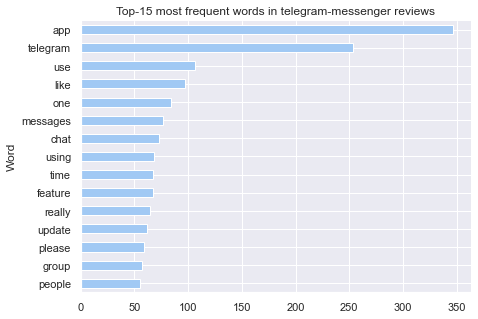

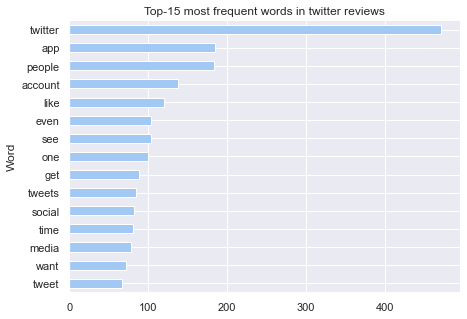

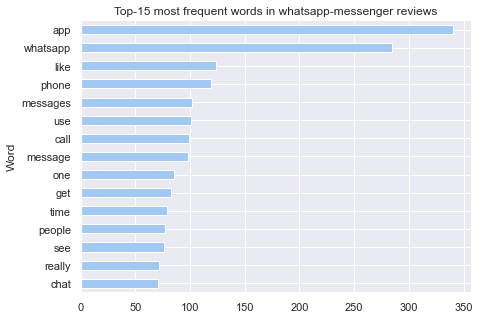

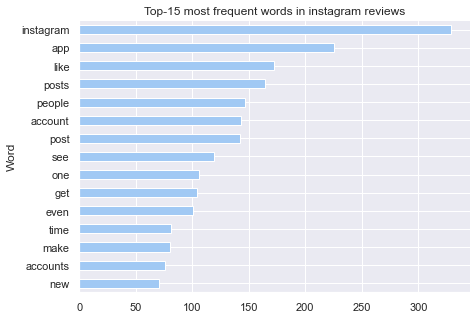

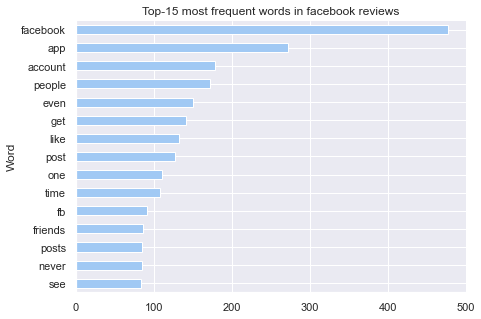

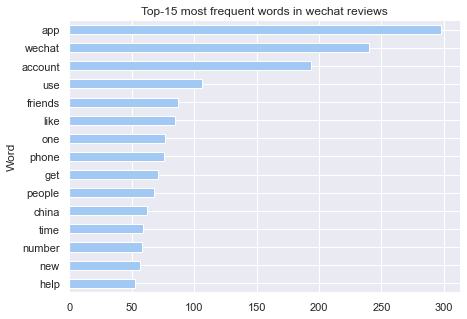

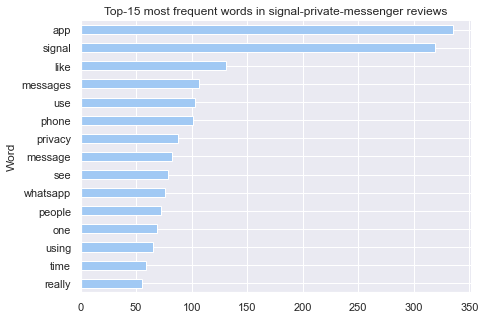

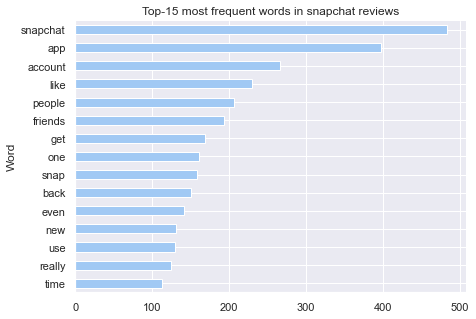

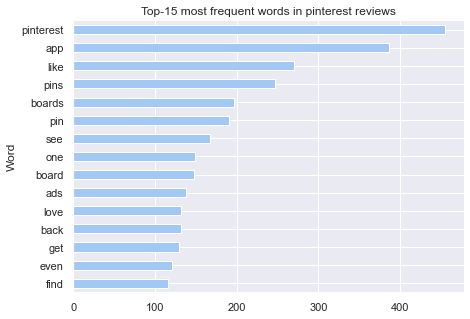

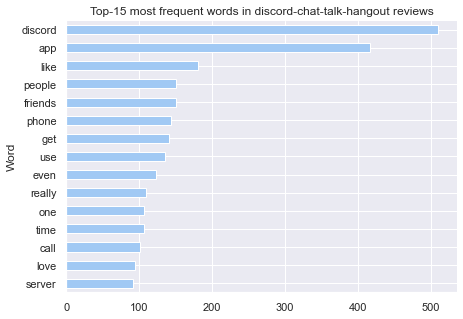

In [23]:
## Build barcharts for every app
for app in df['Flag'].unique():
    targetdf = df[df['Flag'] == app]
    targetdf[:num].sort_values(by = 'Count').plot.barh(x = 'Word', 
                                                y = 'Count', 
                                                figsize=(7,5), 
                                                legend = False, 
                                                title = 'Top-'+str(num)+' most frequent words in '+app+' reviews');